In [1]:
import math
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import time
import datetime
from statsmodels import robust
import matplotlib as mpl
from matplotlib import gridspec
import pylab
from matplotlib import cm
from pytz import timezone


In [2]:
#overlay = cv2.imread("Black Frame with a White Oval.png",0)
#protomap = cv2.imread("Prototype Map.png",0)

In [3]:
#cv2.imshow('Overlay',overlay)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [4]:
#newoverlay = overlay/255
#cv2.imshow("Overlay",overlay)
#cv2.waitKey(0)
#cv2.destroyAllWindows()


In [5]:
#cv2.imshow("Prototype Map",protomap)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [6]:
#newmap = protomap/255
#cv2.imshow("Prototype Map",newmap)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [7]:
#totalmap = newmap*newoverlay
#cv2.imshow("Totalmap",totalmap)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [8]:
Cloudmap = cv2.imread("Cloudmap.png",0)
kernel = np.ones((20,3),np.uint8)


ret,threshCloud = cv2.threshold(Cloudmap,108,255,cv2.THRESH_BINARY_INV)
threshCloudOpen = cv2.morphologyEx(threshCloud, cv2.MORPH_OPEN, kernel)
threshCloudFinal = cv2.morphologyEx(threshCloudOpen, cv2.MORPH_CLOSE, kernel)
cv2.imshow("Threshcloud", threshCloudFinal)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [19]:

# Load angdist/pixel document [ratio, xloc, yloc]
star_ratios = np.loadtxt('loc_and_ratios.txt')

# Find center of data
midpoint = (720/2,480/2)

# Loop of angles to rotate through
rads = np.arange(0,2*np.pi,np.deg2rad(5))

empty = []

for i in np.arange(0,len(rads)):
    # rotate original by ang radians
    ang = rads[i]
    
    # Make everything centered at (0,0)
    xs = star_ratios[:,1]-midpoint[0]
    ys = star_ratios[:,2]- midpoint[1]
    
    # Rotation matrix!
    rota = [[np.cos(ang), -np.sin(ang)],[np.sin(ang),np.cos(ang)]]
    mul = np.matmul(rota,[xs,ys])
    trans = np.transpose(mul)
    
    # Move things back to way they were
    xs2 = trans[:,0]+midpoint[0]
    ys2 = trans[:,1]+midpoint[1]
    
    # Append to array
    rotated_group = np.column_stack((star_ratios[:,0],xs2,ys2))
    if i == 0:
        all_rotated_copies = rotated_group
    else:
        all_rotated_copies = np.vstack((all_rotated_copies,rotated_group))

In [20]:
# Only care about data points that fall within our camera pixel regions

cond1 = (all_rotated_copies[:,1]>=0)&(all_rotated_copies[:,1]<=720)
cond2 = (all_rotated_copies[:,2]>=0)&(all_rotated_copies[:,2]<=480)
cond12 = cond1&cond2

In [21]:
# Here we make the different squares have different ratio values

# This inc can be changed to make squares different sized
inc = 40
xdivs = np.arange(0,720+inc,inc)
ydivs = np.arange(0,480+inc,inc)
ydivs = ydivs[::-1]

# Create empty array
empty = np.zeros((len(ydivs)-1,len(xdivs)-1))

# Look in each square region
for i in np.arange(0,len(xdivs)-1):
    left = xdivs[i]
    right = xdivs[i+1]
    for j in np.arange(0,len(ydivs)-1):
        bottom = ydivs[j+1]
        top = ydivs[j]
        
        # Look at all data points within x and y bounds
        cond_x = ((all_rotated_copies[:,1] >= left)&(all_rotated_copies[:,1] < right))
        cond_y = ((all_rotated_copies[:,2] >= bottom)&(all_rotated_copies[:,2] < top))
        cond_both = (cond_x&cond_y)
        subset = all_rotated_copies[cond_both]
        
        # If anything is in there, average the ratios and append to empty array
        if len(subset) > 0:
            empty[j,i] = np.average(subset[:,0])
        else:
            empty[j,i] = 0

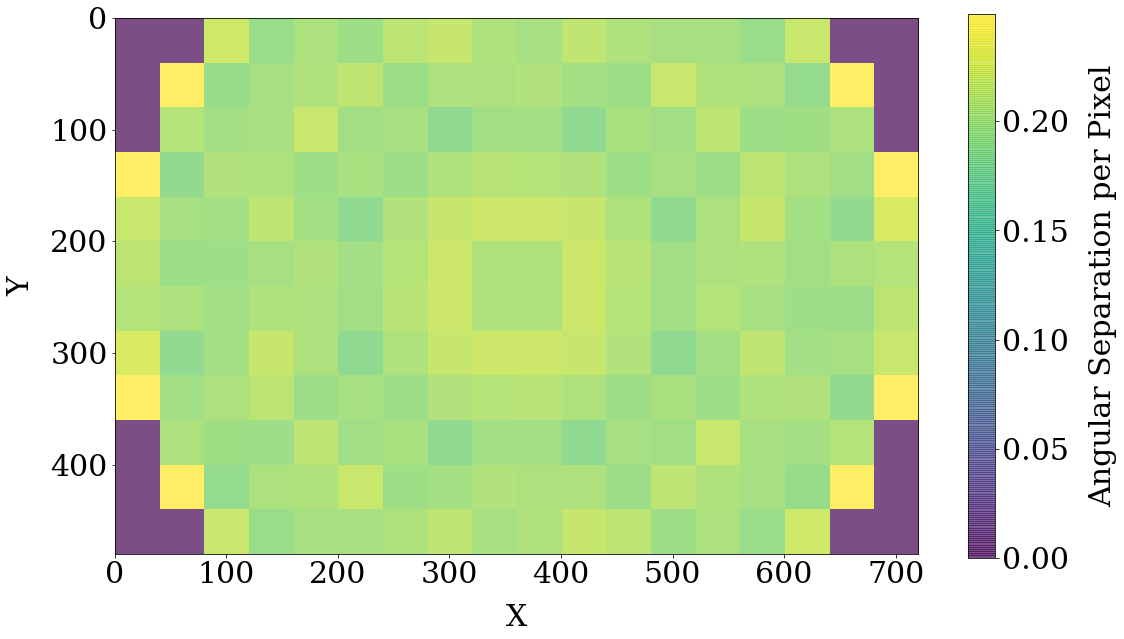

In [22]:
### plot of ratios with colorbar!!

fig = plt.figure(figsize=(18,10))
ax3 = plt.subplot(1,1,1)

#plt.imshow(pic, cmap='gray')

plt.imshow(empty,
           cmap = 'viridis', #setting the color map
           origin = 'lower', # IMPORTANT, or else the upper left will be your origin!
           extent = [0,720,480,0], # imshow doesn't know the boundaries otherwise
           alpha=0.7
          )

color_bar = plt.colorbar()
#plt.scatter(all_rotated_copies[:,1],all_rotated_copies[:,2], color='white', s=1)


plt.xlim(0,720)
plt.ylim(480,0)

cbytick_obj = plt.getp(color_bar.ax.axes, 'yticklabels')                #tricky
plt.setp(cbytick_obj, color='black')

plt.ylabel('Y', labelpad=15,fontsize=30)
color_bar.set_label('Angular Separation per Pixel', labelpad=20, color='black')
pylab.rc('font', family='serif', size=30)
plt.xlabel('X', labelpad=15, fontsize=30)

#fig.patch.set_facecolor('black')
#ax3.spines['bottom'].set_color('white')
#ax3.spines['top'].set_color('white')
#ax3.spines['left'].set_color('white')
#ax3.spines['right'].set_color('white')
#ax3.xaxis.label.set_color('white')
#ax3.tick_params(axis='x', colors='white')
#ax3.yaxis.label.set_color('white')
#ax3.tick_params(axis='y', colors='white')

fig.savefig('Cloud_Analysis_Map_Thingy.png', facecolor=fig.get_facecolor(), transparent=True)


plt.show()

#fig.savefig('images/boxes_colored.png', facecolor=fig.get_facecolor(), transparent=True, bbox_inches='tight')

In [23]:
cloudmapAnalysis = empty

In [24]:
cloudmapAnalysis

array([[0.        , 0.        , 0.22058637, 0.19380418, 0.20169589,
        0.20341152, 0.20675743, 0.2155818 , 0.20160972, 0.20711157,
        0.21960296, 0.2132165 , 0.19727154, 0.20445362, 0.19380418,
        0.22376464, 0.        , 0.        ],
       [0.        , 0.24915821, 0.19167958, 0.20445362, 0.20660517,
        0.22009248, 0.19723566, 0.20136717, 0.20799798, 0.20631521,
        0.20608951, 0.1957546 , 0.21452185, 0.20660517, 0.20169589,
        0.19294654, 0.24915821, 0.        ],
       [0.        , 0.20484539, 0.19849719, 0.19727154, 0.21452185,
        0.19939671, 0.20409269, 0.18824759, 0.19964535, 0.19856396,
        0.18844632, 0.20200041, 0.19939671, 0.22009248, 0.20341152,
        0.20120566, 0.2091887 , 0.        ],
       [0.24915821, 0.19936789, 0.20544007, 0.2132165 , 0.1957546 ,
        0.20200041, 0.19726958, 0.20736006, 0.21076446, 0.21190694,
        0.20714481, 0.19726958, 0.20409269, 0.19723566, 0.20675743,
        0.20800709, 0.19012155, 0.24915821],
    

In [15]:
NewCloudMapAnalysis = cv2.resize(cloudmapAnalysis,(720,480))

In [16]:
Final = NewCloudMapAnalysis*threshCloudFinal

In [25]:
Summed = np.sum(Final)
Summed

15953987.770694356

In [26]:
Percentage = ((480*720))
Percentage

345600